In [18]:
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import math
from collections import Counter
import pandas as pd
import warnings
import json
import os
import scipy

# Allow python to import modules from the preprocessing folder
sys.path.append("src/preprocessing/")
warnings.filterwarnings("ignore") # For seaborn

from load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Table of contents
Given the multiple sources of data and the various steps required to set up our future analysis, this notebook is relatively large. To make assessment of our work easier, we provide a table of contents with dynamic links using html anchors for your convenience. Sadly, the dynamic links **do not work** on Github's web interface, so we encourage you to download this notebook and open it in the browser of your choice.

## [Part 0: Requirements](#part_0_title)

### &emsp; [Download data](#part_0_download_data)

## [Part I: Load, explore and join movie datasets](#part_1_title)

### &emsp; [CMU dataset](#part_1_cmu)

#### &emsp; &emsp; [CMU characters](#part_1_cmu_characters)
#### &emsp; &emsp; [CMU movies](#part_1_cmu_movies)
#### &emsp; &emsp; [CMU plots](#part_1_cmu_plots)
#### &emsp; &emsp; [CMU tropes](#part_1_cmu_tropes)

### &emsp; [IMDb dataset](#part_1_imdb)

#### &emsp; &emsp; [IMDb ratings](#part_1_imdb_ratings)
#### &emsp; &emsp; [IMDb titles](#part_1_imdb_title)
#### &emsp; &emsp; [IMDb principals](#part_1_imdb_principals)
#### &emsp; &emsp; [IMDb people](#part_1_imdb_people)

### &emsp; [Joining titles with ratings](#part_1_imdb_title_with_ratings)

### &emsp; [Joining CMU movies & plots with IMDb titles & ratings](#part_1_cmu_movies_joined_imdb_title_with_ratings)

### &emsp; [Joining IMDb people with IMDb principals](#part_1_imdb_people_with_principals)

### &emsp; [Filtering CMU characters](#part_1_cmu_filter_characters)

### &emsp; [Joining CMU characters with IMDb people & principals](#part_1_imdb_actors_characters_with_cmu_characters)

### &emsp; [Part I summary](#part_1_summary)

#### &emsp; &emsp; [Saving](#part_1_saving)

## [Part 2: Character tropes / Personas](#part_2_title)

### &emsp; [TVTropes personas](#part_2_tv_tropes_personas)

#### &emsp; &emsp; [Analyse tropes characters](#part_2_tv_tropes_per_actor)
#### &emsp; &emsp; [Introduction of the preference metric](#part_2_preference_metric)
#### &emsp; &emsp; [Joining TVTropes with movies](#part_2_tvtropes_joined_movies)

### &emsp; [Joining original paper tropes with actors & characters](#part_2_cmu_personas_joined_character)

### &emsp; [Part II summary](#part_2_summary)

#### &emsp; &emsp; [Saving](#part_2_saving)

## [Part 3: Movie based comfort zones](#part_3_movie_based_comfort_zones)

### &emsp; [Based on genre](#part_3_movie_based_comfort_zones_genre)

#### &emsp; &emsp; [Genre frequency vector per actor](#part_3_genre_freq_vector)
#### &emsp; &emsp; [Joining genre frequency vector with actors & characters & tropes](#part_3_merge_characters_genre_freq_vector)
#### &emsp; &emsp; [Saving](#part_3_saving)

### &emsp; [Part III summary](#part_3_summary)

## [Intermezzo : Possible sources of bias and limitations](#part_3_possible_bias_and_limitations)

## [Part 4: Analysis](#part_4_title)

<hr style="height:2px;border:none;color:#333;background-color:#333;">

# Part 0: Requirements <a name="part_0_title"></a>

## Download data <a name="part_0_download_data"></a>

In order to download all required datasets, run the cell bellow (may take a while the first time).

In [4]:
%run src/preprocessing/download_dataset.py

[x] Fail to register archieve format .gz (make sure requirements.txt are satisfied)
.gz is already registered for "gz"
[+] Found cached dataset for url https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/name.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.ratings.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.principals.tsv.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.cond.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureFile.txt.gz
[+] Found cached dataset for url http

# Part I: Load, explore and join movie datasets <a name="part_1_title"></a>

## CMU dataset <a name="part_1_cmu"></a>

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [44]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters <a name="part_1_cmu_characters"></a>

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [45]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
420079,28670423,/m/0czf7dh,1935,NaN,1920-03-09,M,NaN,NaN,Douglas Haig,14.0,/m/0hzvkpp,NaN,/m/0czf092
149705,2609661,/m/07rhc5,1949-10-28,Pablo Rodriguez,1920-11-25,M,1.83,/m/09k5jvk,Ricardo Montalbán,28.0,/m/0jvp8m,/m/0h37rhh,/m/0k014
361267,27477214,/m/0c01jnf,1950-11-17,NaN,1915-06-07,F,NaN,NaN,Patricia Roc,35.0,/m/0g9mxry,NaN,/m/03wcbfk
277069,5672796,/m/0dzf2d,1973,NaN,1925-06-06,M,NaN,NaN,Hideji Otaki,47.0,/m/0gz1fjb,NaN,/m/0jsz6z
275973,16029585,/m/03ql9rn,1994,NaN,1946-03-19,M,NaN,NaN,Bigas Luna,47.0,/m/0cs3_52,NaN,/m/07btn6


In [46]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%", end="\n\n")

print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie. Let's investigate a bit.

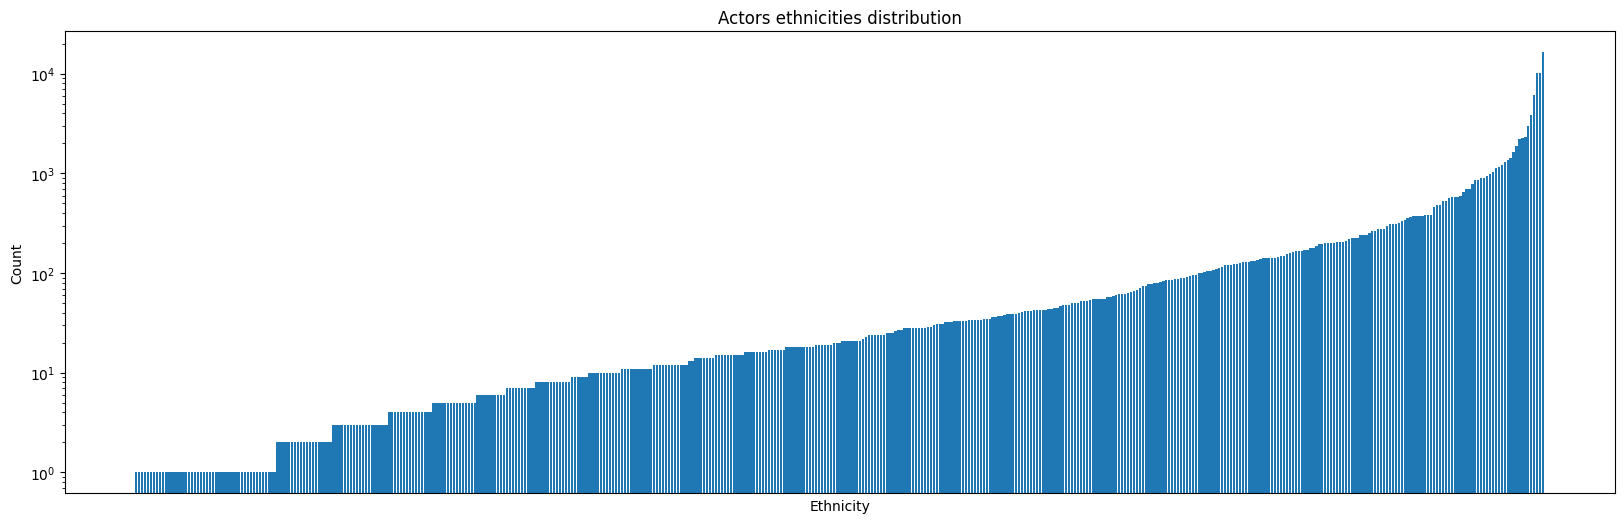

In [47]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies <a name="part_1_cmu_movies"></a>

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [48]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
58834,20692099,/m/051y485,Pudhu Pudhu Arthangal,1989,NaN,NaN,{'/m/07c9s': 'Tamil Language'},{'/m/03rk0': 'India'},{'/m/07s9rl0': 'Drama'}
77002,12214336,/m/02vw3q6,Assume the Position with Mr. Wuhl,2007,NaN,90.0,{},{'/m/09c7w0': 'United States of America'},"{'/m/01z4y': 'Comedy', '/m/0q00t': 'Stand-up c..."
76654,9912631,/m/06_y78c,Ensayo final,1955,NaN,NaN,{'/m/06nm1': 'Spanish Language'},{'/m/0jgd': 'Argentina'},{'/m/01g6gs': 'Black-and-white'}
69337,25659086,/m/09v8xg2,Training Rules,2009-03,NaN,63.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/0hn10': 'LGBT', '/m/0hj3n07': 'Culture & ..."
6457,23799090,/m/06_v731,Jajabara,1975,NaN,NaN,{'/m/01y6qp': 'Oriya Language'},{'/m/03rk0': 'India'},{'/m/07s9rl0': 'Drama'}


In [49]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%
Number of movies for which we have matching character data: 64330


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's performance may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [50]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

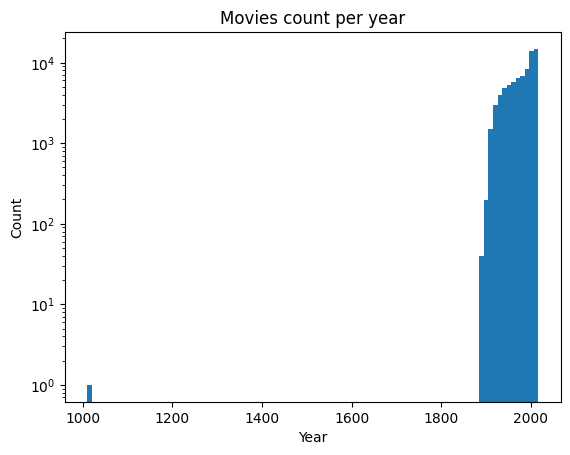

In [51]:
plt.hist(movies_df['movie_release_year'], bins=100)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced 700 years before the invention of potography ! Let's investigate:

In [52]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [53]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

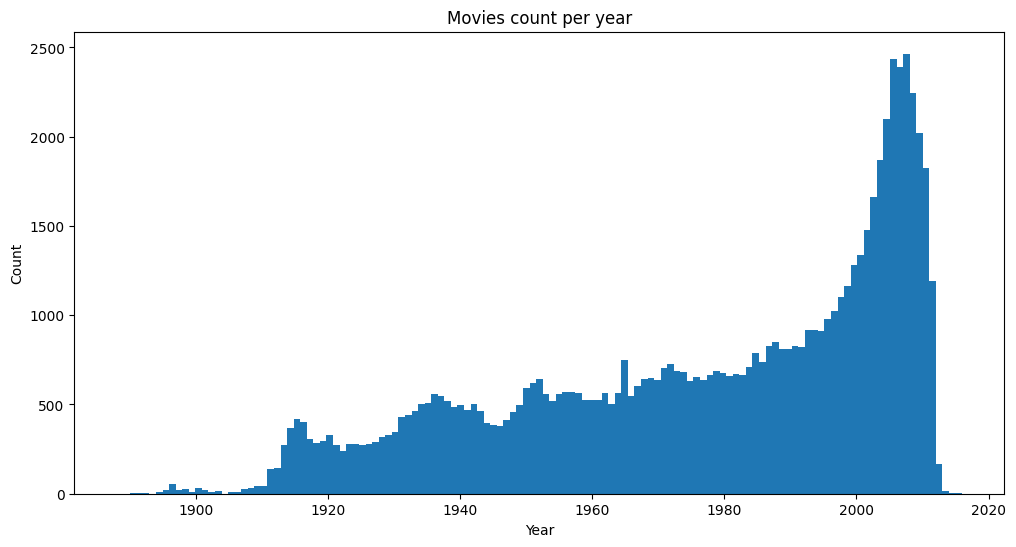

In [54]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plots <a name="part_1_cmu_plots"></a>

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [55]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
18606,883446,"The rocketship MR-1 , returns to Earth after t..."
29068,17344938,"During the Battle of Sarıkamış, the Ottoman ar..."
21193,18302086,"In debt and out of money, Kang Chul-jung is ti..."
8296,8846464,Master Sergeant Dan O'Farrell is a G.I. on an ...
1621,16771910,"In the closing days of World War II, a small G..."


In [56]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes <a name="part_1_cmu_tropes"></a>

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [57]:
tvtropes_df.sample(5)

,trope_name,character_data
424,slacker,"{'char': 'Shaun', 'movie': 'Shaun of the Dead'..."
122,corrupt_corporate_executive,"{'char': 'James McCullen - 1641', 'movie': 'G...."
430,slacker,"{'char': 'Dewey Finn', 'movie': 'School of Roc..."
213,dumb_muscle,"{'char': 'Fezzik', 'movie': 'The Princess Brid..."
215,eccentric_mentor,"{'char': 'Aughra', 'movie': 'The Dark Crystal'..."


In [58]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset <a name="part_1_imdb"></a>

We need to define a metric of "success" of a film. Even if we are already provided with the `box_office` column in the cmu dataset, it only includes data for the bigger movies, wihch represent only 10% of the movies. We have therefore decided to use the imdb rating of the film as a metric defining its performance.

We also used the `people` and `principals` collections from IMDb to enrich the `characters` collection from the CMU corpus, reducing the amount of missing information.

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [59]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

In [60]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
9536610,tt10594090,7,nm2276735,writer,\N,\N
40828444,tt29387340,3,nm12105472,actress,\N,"[""Amudha""]"
13697391,tt11833880,2,nm1029736,self,\N,"[""Self - Host""]"
32348991,tt21637606,2,nm1379134,actress,\N,"[""Genevieve Saavedra""]"
40599598,tt2923596,2,nm0304792,self,\N,"[""Self - Color Commentator""]"


### Ratings <a name="part_1_imdb_ratings"></a>

In [61]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
1346371,tt9310742,6.6,14
1334245,tt9033310,9.2,18
1054296,tt3753206,2.9,183
1343120,tt9218046,8.0,1197
177201,tt0295231,3.7,169


We have 1365868 movies for which we have a rating.


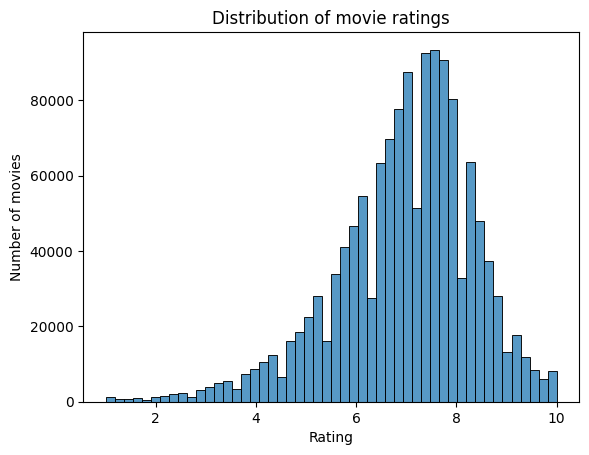

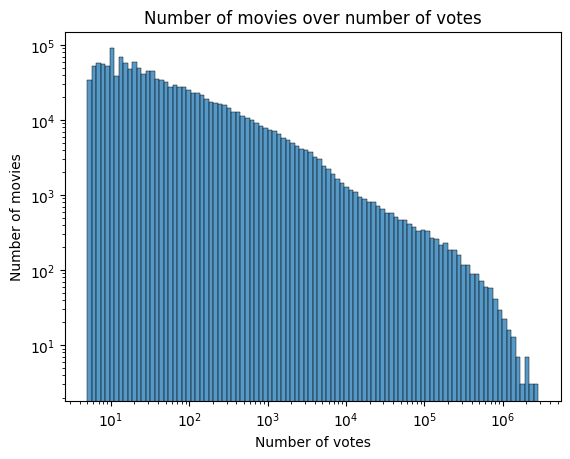

In [62]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100, log_scale=True)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Titles <a name="part_1_imdb_title"></a>

In [63]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
7512856,tt3771900,movie,Arsho,Arsho,0,2014,\N,99,[Romance]
177608,tt0184281,movie,Black Bimbos in Heat,Black Bimbos in Heat,1,1989,\N,\N,[Adult]
8586064,tt6195526,movie,The Cancer Conflict,The Cancer Conflict,0,2021,\N,\N,[Documentary]
327371,tt0342052,movie,Land of Dreams,Ard el ahlam,0,1956,\N,\N,"[Crime, Drama]"
6391819,tt26898886,movie,Trauma in Paradise,Trauma in Paradise,0,2020,\N,\N,[Drama]


In [64]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 651888 movie titles


### Principals <a name="part_1_imdb_principals"></a>

In [65]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons", end="\n\n")

imdb_principals_df.sample(5)

We have 58900432 principals records
We have 12 categories
We have 5169350 unique persons



,tconst,ordering,nconst,category,job,characters
721281,tt0084558,10,nm0825279,production_designer,\N,\N
13016813,tt11630076,8,nm9009760,writer,\N,\N
22304281,tt14850906,1,nm6003787,self,\N,"[""Self (host"",""creator)""]"
51188025,tt7180284,6,nm2145337,director,\N,\N
56332949,tt9047818,7,nm1231177,producer,producer,\N


### People <a name="part_1_imdb_people"></a>

In [66]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")

imdb_people_df.sample(5)

We have 12978070 people records
We have 12978070 unique persons


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
1994679,nm11138784,Vanessa Mitma,\N,\N,[actress],[tt11299870]
5940208,nm15416579,Jacob Vouza,\N,\N,NaN,[\N]
4177778,nm13440937,Sama Goldie,\N,\N,NaN,[\N]
9321384,nm5370918,Dave Cote,\N,\N,[editor],[tt2525316]
4905335,nm14243738,Ahmed Sami,\N,\N,"[assistant_director, editor, director]","[tt12204810, tt9011712, tt23753088]"


## Merge IMDb movie titles with IMDb ratings <a name="part_1_imdb_title_with_ratings"></a>

In [67]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')

total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

imdb_title_with_rating.sample(5)

We have 294744 movies with ratings


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
77693,tt0172918,movie,Oni ne proydut,Oni ne proydut,0,1965,\N,77,"[Drama, War]",4.7,10
119213,tt0369299,movie,Brush with Death,Brush with Death,0,1990,\N,90,"[Action, Crime, Drama]",6.0,11
13581,tt0035875,movie,Fighting Valley,Fighting Valley,0,1943,\N,60,"[Drama, Western]",5.1,17
260794,tt5475564,movie,National Theatre Live: Jane Eyre,National Theatre Live: Jane Eyre,0,2015,\N,200,"[Drama, Music]",7.9,378
183314,tt15276374,movie,Ya Ben Ölürsem,Ya Ben Ölürsem,0,2022,\N,100,[Drama],6.7,6


There is more than one quarter of a million movies for which we have at least one rating. We have clearly much more data to work with than with box office revenue. Furthermore, there is a substantial amount of movies who have at least a few hundreds votes. This will allow us to get better confidence interval and reduce uncertainty in our analysis.

## Merge CMU movies and plot summaries with IMDB titles and ratings <a name="part_1_cmu_movies_joined_imdb_title_with_ratings"></a>

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [68]:
translation_id = load_translation_df()

imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

# Enriching CMU data
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44467 movies with corresponding ratings


In [69]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
35910,tt0439511,78,[Documentary],6.6,427,/m/0dgqprc,11601018,Commune,2005,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/0jtdp': 'Documentary'},NaN
4354,tt0030820,77,"[Comedy, Music, Romance]",5.0,578,/m/0fqqjkg,29531230,Swing Your Lady,1938-01-08,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01z02hx': 'Sports', '/m/04rlf': 'Music', ...",Promoter Ed Hatch comes to the Ozarks with his...
24850,tt0112740,116,"[Action, Drama, Thriller]",7.3,120380,/m/04sg0b,1317604,Crimson Tide,1995-05-12,157387195.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/0cq22f9': 'Actio...","In post-Soviet Russia, military units loyal to..."
17422,tt0075164,86,"[Drama, Horror]",5.2,2067,/m/0bs02dn,26977302,Satan's Slave,1976-12,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/03npn': 'Horror'},"A young girl, Catherine Yorke , shares a ride ..."
18751,tt0081270,106,"[Comedy, History]",6.3,27,/m/0dddhj8,28857780,Ojciec królowej,1979,NaN,{'/m/05qqm': 'Polish Language'},{'/m/05qhw': 'Poland'},{'/m/02p0szs': 'Historical fiction'},NaN


## Merge IMDb people and IMDb principals <a name="part_1_imdb_people_with_principals"></a>
We now focus on characters and actors. We merge the two dataframes from IMDB and keep records of interest i.e for which the movie is in the collection above.

In [70]:
titles_of_interest = set(cmu_movies_w_imdb_rating["tconst"].to_list())

imdb_people_not_nan = imdb_people_df[imdb_people_df["primaryProfession"].notna()]

# Filter IMDb data to keep actors and actresses
imdb_actors = imdb_people_not_nan[imdb_people_not_nan["primaryProfession"].apply(lambda l : ("actor" in l) or ("actress" in l))].copy()
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()

# Only keep actors and actresses from movies that have a rating
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [71]:
imdb_actors_and_characters.sample(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
15399105,nm2284321,Samuthirakani,1973,\N,"[tt4991384, tt1997455, tt2606826, tt8178634]",tt2544722,"[""Uduman Gani""]"
3891065,nm0310173,Kumar Gaurav,1956,\N,"[tt0091598, tt0294662, tt0249986, tt0246286]",tt0268585,"[""Amar""]"
4520336,nm0382391,Anne Heywood,1931,\N,"[tt0064682, tt0064148, tt0068726, tt0062990]",tt0079228,"[""Evelyn Wyckoff""]"
362247,nm0005068,Vinnie Jones,1965,\N,"[tt0805570, tt0376994, tt0208092, tt0120735]",tt0928375,"[""Mr. Hunter""]"
3988453,nm0320808,Bernard Giraudeau,1947,2010,"[tt0117477, tt0099071, tt0093205, tt0343524]",tt0103710,"[""David""]"


## Filter CMU characters <a name="part_1_cmu_filter_characters"></a>
We keep records of interest in the same fashion as done above

In [72]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
165478,5540939,/m/0drmym,2001-09-16,NaN,1975-04-25,F,1.65,/m/09vc4s,Emily Bergl,26.0,/m/0jw8sf,NaN,/m/0cf4p0
330562,1346469,/m/04vjzm,1966-06-07,NaN,1910-02-17,M,NaN,NaN,Arthur Hunnicutt,56.0,/m/03jsq57,NaN,/m/04xbsk
283812,21447563,/m/05f889z,1957-05-13,NaN,1921-08-28,M,NaN,/m/03ttfc,Fernando Fernan Gomez,35.0,/m/07p4zwc,NaN,/m/05lbhv
257261,76361,/m/0k4d7,1937-12-21,The Magic Mirror,1889-06-27,M,NaN,NaN,Moroni Olsen,NaN,/m/062jfhj,/m/062jfhm,/m/0g6zr3
236688,3671998,/m/09tm6h,1992,NaN,1938-01,M,1.80,NaN,Tom Bower,NaN,/m/03lg3dt,NaN,/m/02pjtlw


## Merge IMDb actors and characters with CMU characters <a name="part_1_imdb_actors_characters_with_cmu_characters"></a>

We merge IMDB character and actor data with the CMU data. We make use of the movie translation dataframe again and the actor translation dataframe. We assume that an actor only plays one role in a movie. This is not necessarily true as some actors may play many roles in the same movie, but we assume that those cases are sufficiently rare so that we can ignore them.

In [73]:
# Actor translation dataframe
actor_translation_df = load_actors_translation_df()
actor_translation_df = actor_translation_df.rename(columns={'imdb_id' : 'actor_imdb_id', 'freebase_id' : 'actor_freebase_id'})

In [74]:
# Prepare the datasets for merging by adding translation information
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.merge(actor_translation_df, how='inner', left_on='nconst', right_on='actor_imdb_id')
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id", "actor_imdb_id"], axis=1)

In [75]:
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='right', left_on=['freebase_id', 'actor_freebase_id'], right_on=['freebase_movie_id', 'freebase_actor_id']).copy()

In [76]:
# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

def get_first_characters(ls):
    """
    Retrieves the first character of the corresponding IMDb column

    Parameters
    ----------
    ls : str
        List-like string of characters
        
    Returns
    -------
    str
        The character name
    """
    
    if isinstance(ls, float) | (ls == "\\N"):
        return np.nan
    return ls.split('"')[1]

# Merge character information
imdb_actors_w_cmu_characters["characters"] = imdb_actors_w_cmu_characters["characters"].apply(get_first_characters)
missing_characters = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['character_name'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_characters, 'character_name'] = imdb_actors_w_cmu_characters.loc[missing_characters, 'characters']

# Drop duplicates and column names
imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_id", "actor_freebase_id", "primaryName", "deathYear", "birthYear", "knownForTitles", "nconst", "tconst", "characters"], axis=1)
imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates(subset="freebase_map_id")
imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.rename(columns={'freebase_movie_id' : 'freebase_id'})

imdb_actors_w_cmu_characters.head(5)

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


## Summary of results for part I <a name="part_1_summary"></a>
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [77]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"[Adventure, Fantasy]",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [78]:
actors_characters.head()

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Saving <a name="part_1_saving"></a>

In [42]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [43]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Character tropes / Personas <a name="part_2_title"></a>

In [79]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas <a name="part_2_tv_tropes_personas"></a>
We now load the 500 personas records we extracted from TVTropes

In [80]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor <a name="part_2_tv_tropes_per_actor"></a>
Let's see if actors have diverse tropes

In [81]:
# We group by actors and aggregate tropes together. We sort the resulting dataframe by the number of tropes
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes", ascending = False)

tvtropes_per_actor.head()

,actor,trope,num_tropes
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5


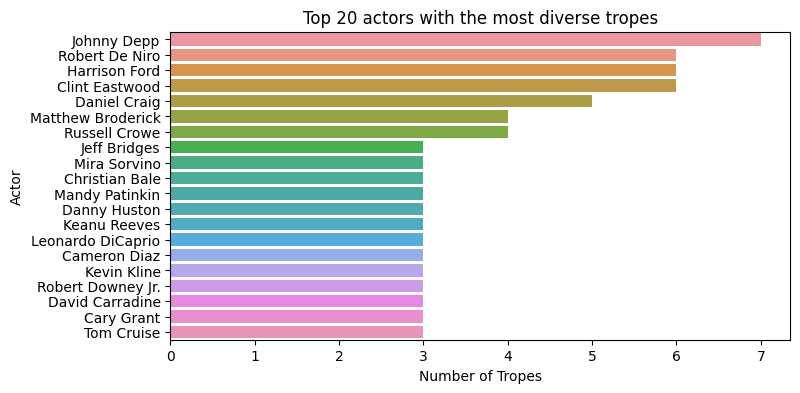

In [82]:
plt.figure(figsize=(8, 4))
sns.barplot(data = tvtropes_per_actor.head(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 actors with the most diverse tropes')
plt.show()

As we can see we have a problem. We only have very few well known actors with multiple personas. This makes further analysis impossible, but we use this very high quality dataset to introduce our metrics

### Preference Metric <a name="part_2_preference_metric"></a>

As describe in the [`README.md`](./README.md#methods), we need a **preference metric** per actor. This metric should measure the tendency for a given actor $A$ to have a preferred trope (or set of tropes). A naïve approach would be to compare the distribution of a given actor $A$ to the uniform distribution of tropes. However a rapid analysis show us that the global tropes distribution is not uniform (and as such a more meaningful metric should be determined).



A more meaningfull metric need to be extracted

- **Cross Entropy based metric**:
       
   The Cross Entropy Metric focuses on the entropy of persona choices given the actor
   $$\text{pref}(\text{actor}) = \frac{ H(\text{Persona}) }{ H(\text{Persona} | \text{Actor} = \text{actor})}$$

   This metric has the following property
   - If the actor $a$ always plays the same persona, then $\text{pref}(a) = +\infty$
   - If the actor $a$ plays each persona randomly (same distribution than the global distribution), then $\text{pref}(a) = 1$

   > Note that this metric is not well-behaved as it is not bounded. We can take the inverse to keep a value between 0 and 1, the value 1 would mean that $A$ plays each persona randomly and 0 would mean that $A$ keeps playing the same persona

In [83]:
# Implementation of the cross entropy per actors
tvtropes_per_actor_filtered = tvtropes_per_actor[tvtropes_per_actor["num_tropes"] > 3].copy()
tvtropes_per_actor_filtered

def compute_entropy(array_like):
    array_like = list(array_like)
    dic = {}
    for elem in array_like:
        dic[elem] = dic.get(elem, 0) + 1
    occurences = np.array(list(dic.values()))
    probabilities = occurences / np.sum(occurences)
    return -np.dot(np.log2(probabilities), probabilities)

H_global = compute_entropy(tvtropes_per_actor_filtered['trope'].sum())

tvtropes_per_actor_filtered['cross_entropy_based'] = H_global / tvtropes_per_actor_filtered['trope'].apply(compute_entropy)
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194


- **Mutual Information**:

   The Mutual Information Metric captures the information gain about the actor's persona choices relative to the global persona distribution
   $$\text{pref}(\text{actor}) = \frac{ H(\text{Persona}) - H(\text{Persona} | \text{Actor} = \text{actor}) }{H(\text{Persona})}$$
      
   This metric has the following property
   - If the actor $a$ always plays the same persona, then $\text{pref}(a) = 1$
   - If the actor $a$ plays each persona randomly (same distribution than the global distribution), then $\text{pref}(a) = 0$

In [84]:
tvtropes_per_actor_filtered['mutual_information_based'] = (H_global - tvtropes_per_actor_filtered['trope'].apply(compute_entropy)) / H_global
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based,mutual_information_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494,0.374411
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055,0.430542
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315,0.452749
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254,0.426360
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194,0.471792


### Analyse frequency of tropes when joined with our movies <a name="part_2_tvtropes_joined_movies"></a>
Get an idea of the distribution of personas.

In [85]:
# We "standardize" movie name and try joining TVTropes personas and Movies
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

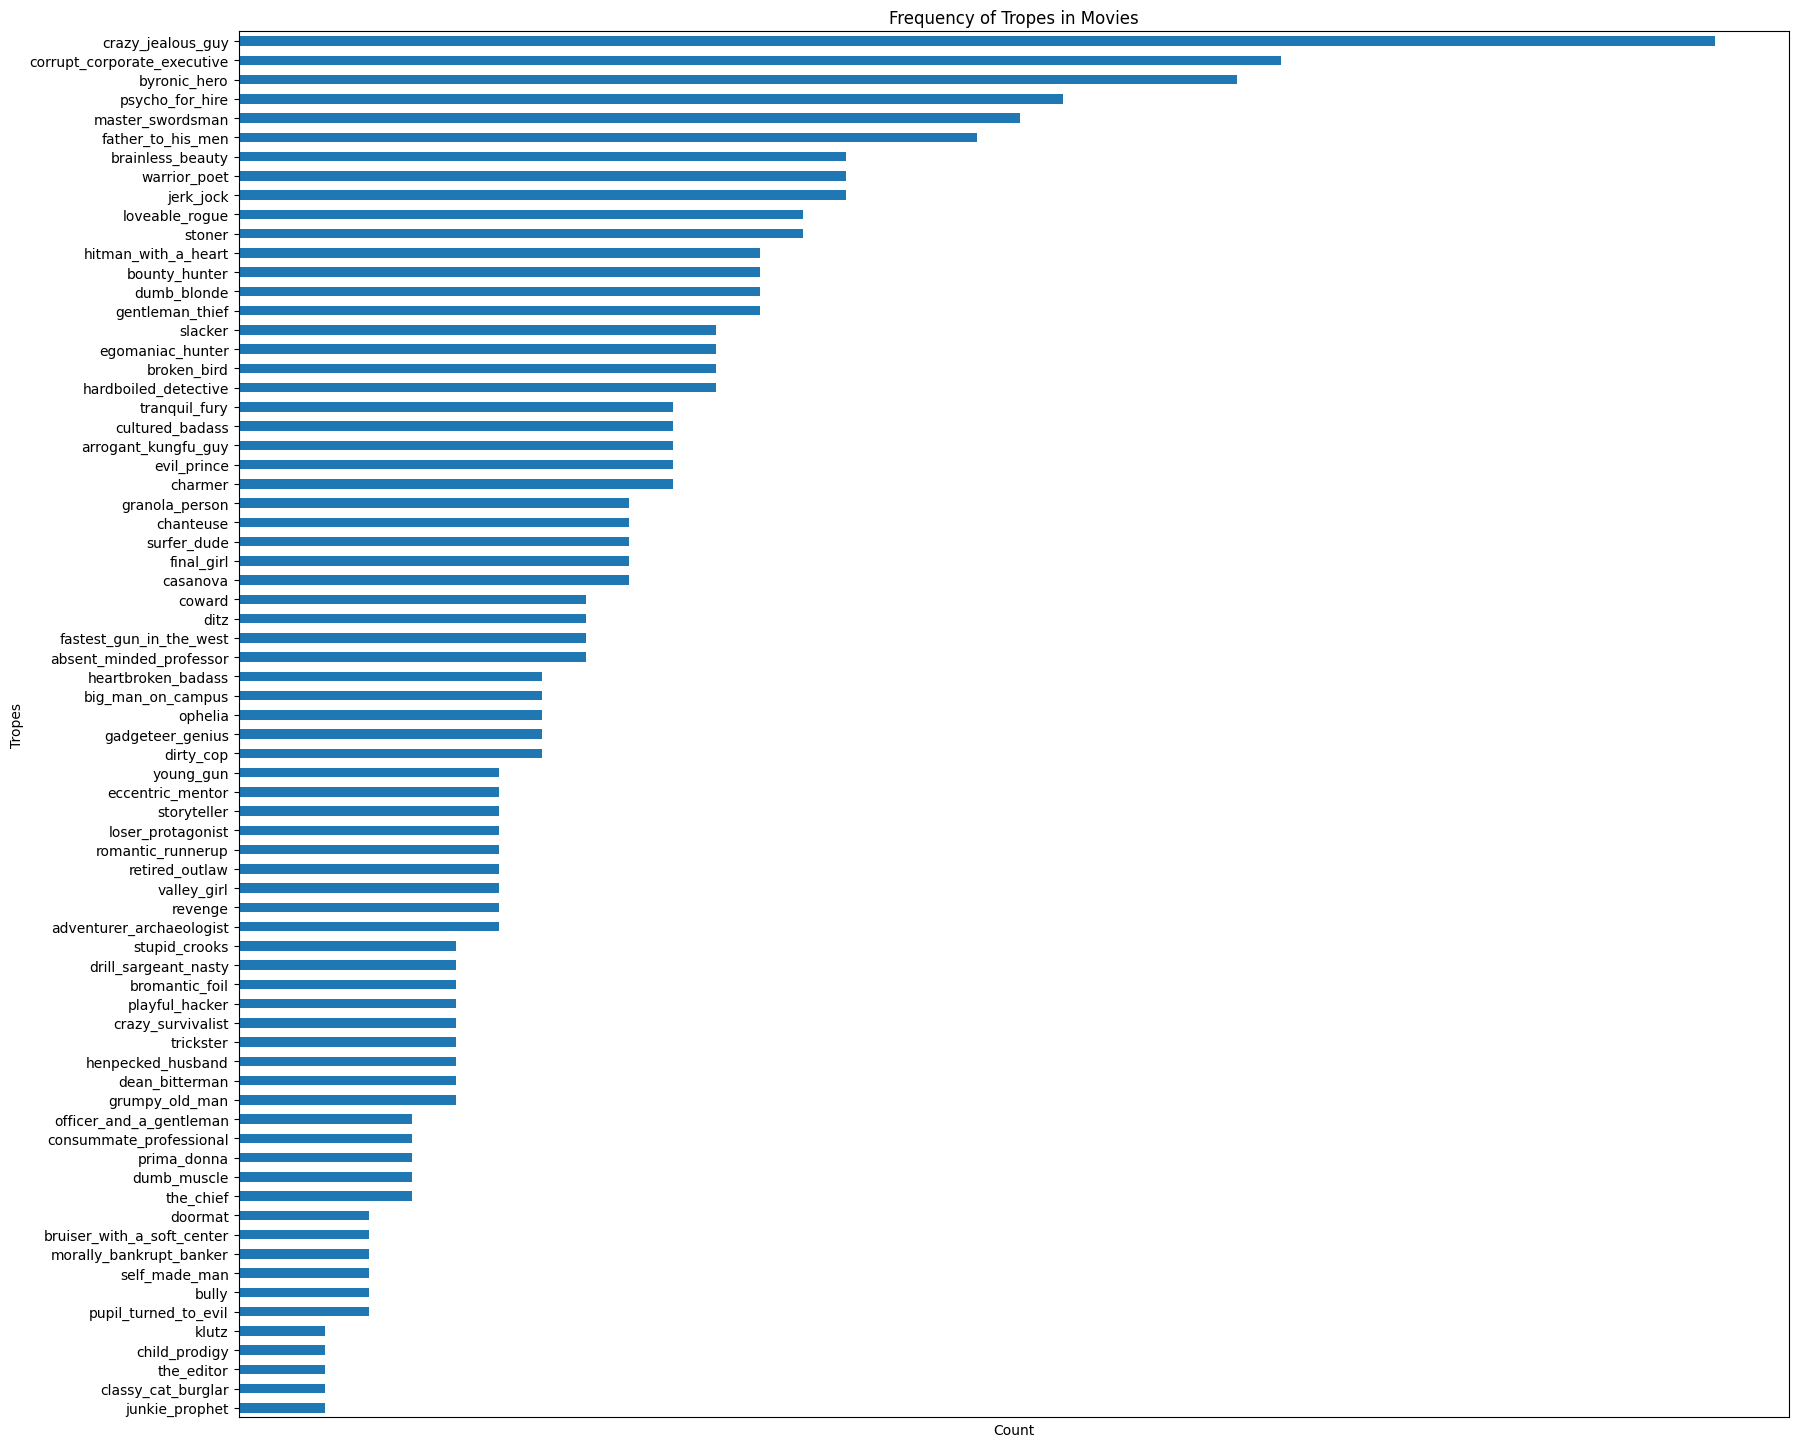

In [86]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh', xticks=[])
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU tropes with actors & characters <a name="part_2_cmu_personas_joined_character"></a>

We merge the actors and characters information we extracted in part I with the tropes from the original paper

In [87]:
cmu_personas = load_personas()
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
49076,e12,1934924,Where the Sidewalk Ends,father,Morgan 's father,4,28,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
95059,e8,286893,Rudy,assistant,a teaching assistant at his junior college,4,17,"[0.0, 0.0, 0.19, 0.01, 0.0, 0.0, 0.02, 0.0, 0...."
143169,e32,5523710,The Devil's Backbone,they,many orphans,5,21,"[0.0, 0.33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
27189,e2,14693181,Of Human Bondage,she,her,5,2,"[0.0, 0.03, 0.21, 0.09, 0.0, 0.01, 0.0, 0.0, 0..."
144669,e6,5654699,Simhadri,Indu,Indu,8,46,"[0.0, 0.01, 0.01, 0.02, 0.0, 0.02, 0.02, 0.0, ..."


In [88]:
# Rename mapping columns and perform inner join
cmu_personas = cmu_personas.drop(columns=['secondary_name', 'full_name', "wiki_id"])
cmu_personas = cmu_personas.rename(columns={'freebase_id' : 'freebase_map_id'})
movies_personas_cmu = cmu_personas.merge(actors_characters, on='freebase_map_id')

In [89]:
print(f"We have {len(movies_personas_cmu)} records for characters and their corresponding trope")

We have 11985 records for characters and their corresponding trope


This offers us one possiblity for further analysis, as we have more than 30'000 records

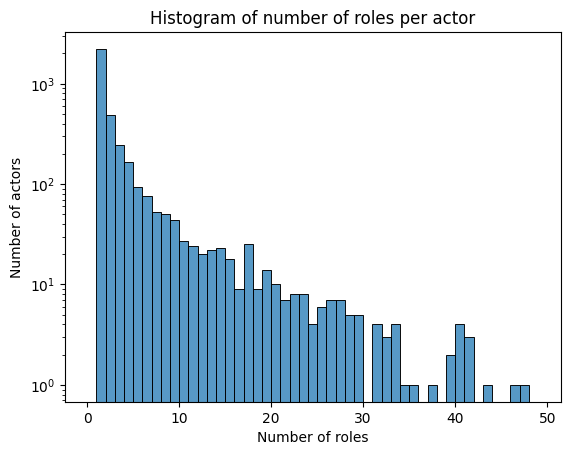

In [90]:
characters_per_actor = movies_personas_cmu[['freebase_actor_id', 'freebase_map_id']].groupby(by='freebase_actor_id').count()
sns.histplot(data=characters_per_actor, x='freebase_map_id', bins=range(50))
plt.yscale('log')
plt.xlabel("Number of roles")
plt.ylabel("Number of actors")
plt.title("Histogram of number of roles per actor")
plt.show()

In [91]:
print(f"Number of actors with 5 roles or more : {len(characters_per_actor[characters_per_actor['freebase_map_id'] >= 5])}")
print(f"Number of actors with less than 5 roles : {len(characters_per_actor[characters_per_actor['freebase_map_id'] < 5])}")

Number of actors with 5 roles or more : 603
Number of actors with less than 5 roles : 3106


With 5 roles or more, we consider that we can decide "with some confidence" if an actor has a preferred persona or not (under this threshold, data may not be significant enough). There is a reasonable amount of actors for which we gathered enough roles to be confident in our analysis (1481 actors have more than 5 personas). 

Nevertheless, in further methods, we may decide to only keep actors with a number of roles greater than some threshold (to be confident in our metric computations). This may become a source of bias as there is more chance that an actor is successful if he plays in more movies (thus our analysis may become relevant only for "successful" actors and not for actors in general). 

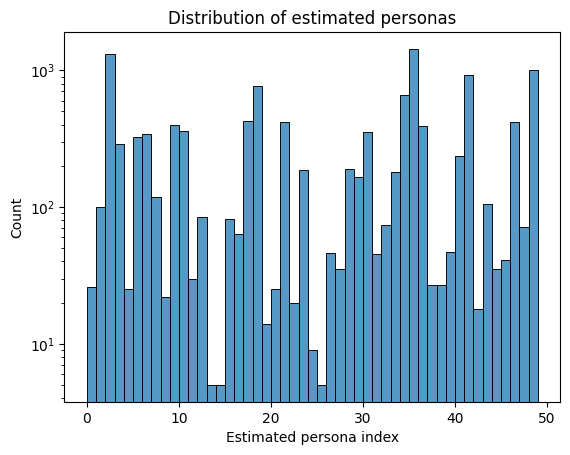

In [92]:
sns.histplot(data=movies_personas_cmu, x='estimated_trope', bins=range(50))
plt.yscale("log")
plt.xlabel('Estimated persona index')
plt.ylabel('Count')
plt.title('Distribution of estimated personas')
plt.show()

The distribution of estimated personas is very heterogeneous, some personas only have one representative ! This can lead to very high variance. For instance suppose for those personas that their representative (movie role) is in a very good movie (according to our movies' success evaluation), then we will deduce that this persona always lead to very good rating and will bias our analysis. We hope that this issue can be mitigated with uncertainty estimation.

Because of all of those possible limitations, to be even more confident with our result, we introduce another way to determine an actor's comfort zone which is based on the movies' genres (presented in next part).

## Summary of results for part II <a name="part_2_summary"></a>
We took the dataframe containing everything related to actors, their features and characters they played in a given movie from the results of part I and added the character tropes distribution from the original CMU paper. We have also defined our preference metrics and showed an example computation on a subsample of data.

In [93]:
actors_characters_personas = movies_personas_cmu.copy()
actors_characters_personas.head()

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_character_id,freebase_actor_id
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0,...",nm0001588,"tt0101587,tt0057345,tt0046303,tt0098439",tt0042539,"[""Pigeon Lane""]",/m/02pzjvb,10004330,1950,1919-02-18,M,1.930,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz0m,/m/02t_w8
1,/m/0k52jp,The First of the Few,8,12,"[0.0, 0.02, 0.36, 0.01, 0.0, 0.01, 0.0, 0.0, 0...",nm0001366,"tt0030637,tt0034027,tt0025748,tt0031381",tt0034734,"[""R.J. Mitchell""]",/m/03y7jr,1001896,1942,1893-04-03,M,NaN,/m/041rx,Leslie Howard,NaN,/m/0hhch2q,/m/0lcf1
2,/m/02s9nyl,Foul Play,12,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0000331,"tt0085995,tt0080487,tt0092086,tt0104850",tt0077578,"[""Tony Carlson""]",/m/03y9n_,1002717,1978-07-14,1943-10-08,M,1.930,None,Chevy Chase,34.0,/m/02s9nyn,/m/0p_jc
3,/m/0jznfp,Hudson Hawk,5,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.52, 0.03, 0.0, 0.0...",nm0000732,"tt0110413,tt0097216,tt0093565,tt0099871",tt0102070,"[""Tommy Five-Tone""]",/m/0pk1p,100274,1991-05-24,1933-06-20,M,1.910,/m/0xnvg,Danny Aiello,57.0,/m/0lyzr6x,/m/01r7t9
4,/m/02vc5km,Red Dust,3,40,"[0.0, 0.0, 0.13, 0.01, 0.0, 0.05, 0.02, 0.0, 0...",nm0252230,"tt0301199,tt7533152,tt2024544,tt0379786",tt0388364,"[""Alex Mpondo""]",/m/02p_921,10028410,2004,1977-07-10,M,1.778,/m/0278pqj,Chiwetel Ejiofor,26.0,/m/0h32y39,/m/05vsxz


### Saving <a name="part_2_saving"></a>

In [59]:
actors_characters_personas.to_json(os.path.join(SAVE_PATH, "characters_personas.json"), orient='records')

# Part III: Movie-based comfort zones <a name="part_3_movie_based_comfort_zones"></a>

We investigate the possiblity of coming up with comfort zones by analysing movie features for a given actor instead of personas. Defining an actor's comfort zone as such seems at first glance like a reasonable approach. Indeed, even when an actor embodies diverse characters, if they still play for the same type of movies this would raise questions about whether they are truly venturing beyond their comfort zone. Whereas with totally different genres (such as Sport and Action/Adventure movies for instance), we would be more confident that the difference is significant enough to make a difference for the critics.

However this is a much more coarse-grained analysis as differences in actors' tropes may still be really noticeable even for similar genres.

In [60]:
# Load results of part I
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))

# Load results of part II
actors_characters_personas = pd.read_json(os.path.join(SAVE_PATH, "characters_personas.json"))

In [61]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,485,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,858,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"[Adventure, Fantasy]",5.0,70,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [62]:
actors_characters.head()

,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,None,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,None,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,None,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [63]:
all_data = movies.merge(actors_characters, how="inner", on=["freebase_id", "wiki_movie_id"])
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000147,100,"[Documentary, News, Sport]",5.3,485,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,...,None,1866-09-01,M,NaN,None,James J. Corbett,NaN,/m/0gvztx7,None,/m/037fcq
1,tt0000574,70,"[Action, Adventure, Biography]",6.0,858,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,None,NaN,None,Mr. Marshall,NaN,/m/0bxl509,None,/m/0bxl506
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,858,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,None,NaN,None,Vera Linden,NaN,/m/0bxl501,None,/m/0bxl4__
3,tt0000574,70,"[Action, Adventure, Biography]",6.0,858,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,M,NaN,None,John Tait,NaN,/m/0k6ktp,None,/m/0k6ksg
4,tt0000574,70,"[Action, Adventure, Biography]",6.0,858,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,None,None,F,NaN,None,Elizabeth Tait,NaN,/m/0k6ktj,None,/m/0k6ks8


In [64]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'release_date', 'character_name', 'actor_birth',
       'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name',
       'release_actor_age', 'freebase_map_id', 'freebase_character_id',
       'freebase_actor_id'],
      dtype='object')

## Based on movie genre <a name="part_3_movie_based_comfort_zones_genre"></a>

In [65]:
# Get rid of the freebase_id genre and create an other column simply containing a list of genres
movie_genre_per_actor = all_data[["freebase_actor_id", "actor_name", "movie_genres"]].copy()
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)

# Group data by actor and aggregate genres by simply putting them in a list
movie_genre_per_actor = movie_genre_per_actor.groupby(["freebase_actor_id", "actor_name"]).agg(list).reset_index()
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)

# Flatten list of lists
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])

# Transform list into dictionary of frequencies
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [66]:
movie_genre_per_actor.head()

,freebase_actor_id,actor_name,total_movies,genres_freq
0,/m/010p3,Adam Carolla,8,"{'Comedy': 8, 'Romance Film': 5, 'Romantic com..."
1,/m/010q36,Fred Rogers,1,"{'Horror': 1, 'Comedy-drama': 1, 'Fantasy': 1,..."
2,/m/010xjr,Richard Harris,50,"{'Drama': 33, 'Adventure': 19, 'Action': 17, '..."
3,/m/0112yl,Toshiro Mifune,40,"{'Drama': 36, 'Japanese Movies': 28, 'World ci..."
4,/m/011_24,Les Brown,2,"{'Romance Film': 2, 'Comedy': 2, 'Musical': 1,..."


### Distribution of some actors

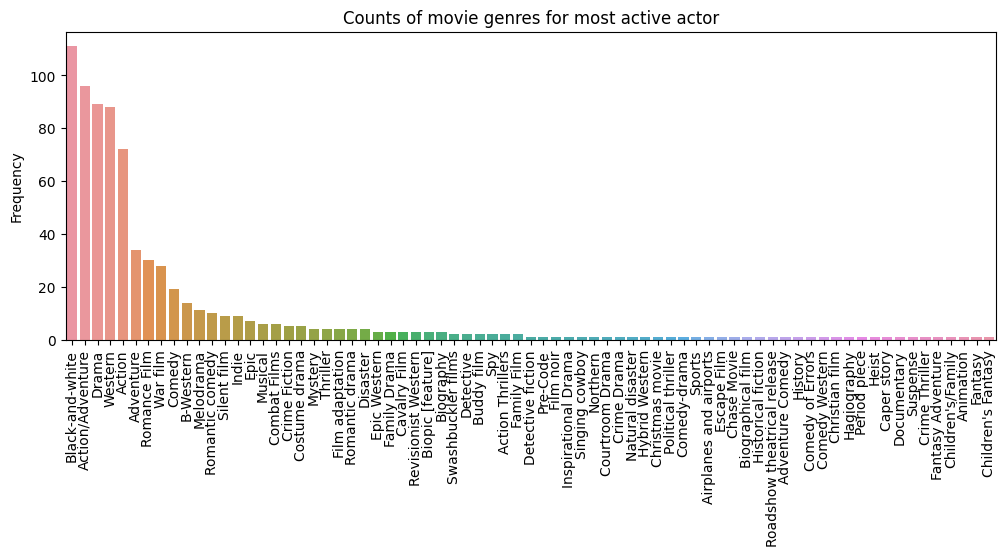

In [67]:
# We check the most active actor distribution, i.e. the one who played the most total movies
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()
actor_1 = top_actors["genres_freq"].iloc[0]

plt.figure(figsize=(12, 4))
plt.title('Counts of movie genres for most active actor')
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

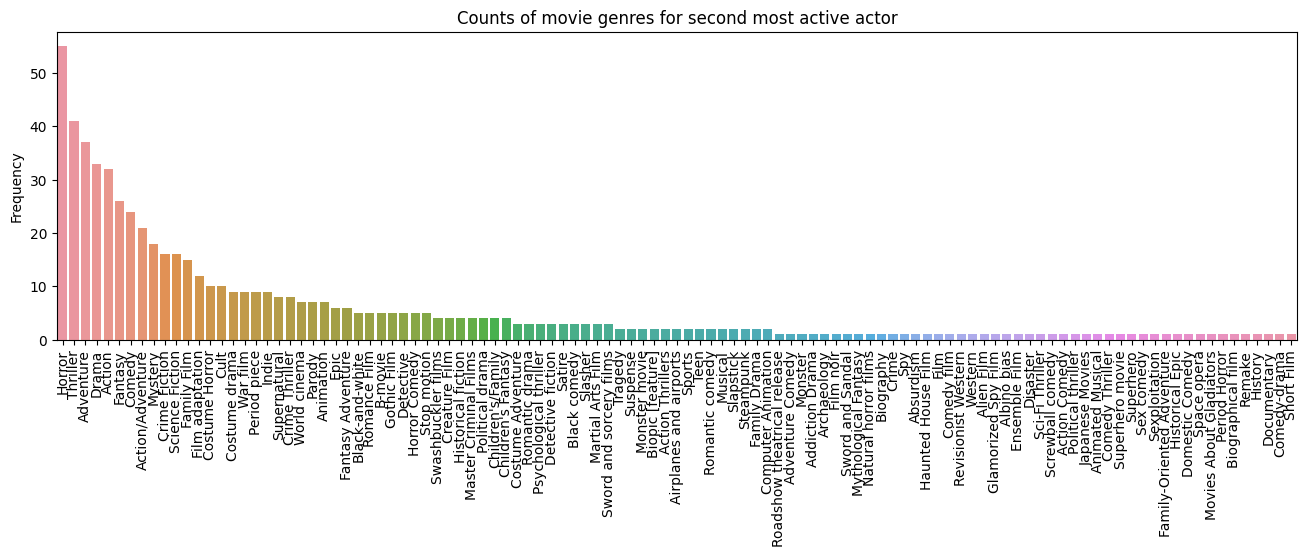

In [68]:
# We check the second most active actor distribution
actor_2 = top_actors["genres_freq"].iloc[1]

plt.figure(figsize=(16, 4))
plt.title('Counts of movie genres for second most active actor')
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Create genre frequency vector <a name="part_3_genre_freq_vector"></a>

In [69]:
# Compute the set of movie genres
movie_genres = all_data["movie_genres"].copy().apply(lambda genres: list(genres.values()))
movie_genres_unique = set()
for genres in movie_genres:
    for genre in genres:
        movie_genres_unique.add(genre)
        
# Unique movie genres sorted alphabetically
movie_genres_unique = sorted(list(movie_genres_unique))

# Save genres for later interpretation of vectors
with open(os.path.join(SAVE_PATH, "movie_genres.json"), "w") as outfile:
    json.dump(movie_genres_unique, outfile)

In [70]:
def create_movie_genre_frequency_vector(genres_dict):
    """
    Transforms the dictionary of movie genre counts into a {0,1} vector of frequencies

    Parameters
    ----------
    genres_dict : dictionary
        keys are movie genres and values are counts
        
    Returns
    -------
    list
        The frequency vector
    """
    # Initialize
    freq_dict = {}
    for genre in movie_genres_unique:
        freq_dict[genre] = 0
    
    # Fill our dictionary
    tot_count = 0
    for genre, freq in genres_dict.items():
        tot_count += freq
        freq_dict[genre] += freq
    
    # Compute frequencies
    if tot_count != 0:
        for genre, freq in freq_dict.items():
            freq_dict[genre] /= tot_count
    
    return list(freq_dict.values())

In [71]:
movie_genre_freq_vector = movie_genre_per_actor.copy()
movie_genre_freq_vector["genres_freq"] = movie_genre_per_actor["genres_freq"].apply(create_movie_genre_frequency_vector)
movie_genre_freq_vector = movie_genre_freq_vector.drop(["actor_name"], axis=1)

In [72]:
movie_genre_freq_vector.head()

,freebase_actor_id,total_movies,genres_freq
0,/m/010p3,8,"[0.0, 0.0, 0.02857142857142857, 0.0, 0.0, 0.02..."
1,/m/010q36,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/m/010xjr,50,"[0.0, 0.0, 0.06854838709677419, 0.0, 0.0080645..."
3,/m/0112yl,40,"[0.0, 0.0, 0.039647577092511016, 0.00440528634..."
4,/m/011_24,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Merge genre frequency with actors and characters <a name="part_3_merge_characters_genre_freq_vector"></a>

In [73]:
actors_characters_personas_genres = actors_characters_personas.merge(movie_genre_freq_vector, on="freebase_actor_id", how="inner").copy()

### Saving <a name="part_3_saving"></a>

In [94]:
# tvtropes_per_actor.to_json(os.path.join(SAVE_PATH, "tvtropes_per_actor.json"), orient='records')
actors_characters_personas_genres.to_json(os.path.join(SAVE_PATH, "characters_personas_genres.json"), orient='records')
actors_characters_personas_genres.head()

In [109]:
df = all_data[["freebase_actor_id", "actor_name", "movie_genres"]]
df.to_json(os.path.join(SAVE_PATH, "actor_movies_with_genre.json"), orient="records")

## Summary of results for part III <a name="part_3_summary"></a>
We have enriched our characters with tropes in part II and genre frequencies in part III. We have setup our two main dataframes for further analysis `movies` and `actors_characters_personas_genres`.

In [149]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,[Romance],5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"[Documentary, News, Sport]",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"[Action, Adventure, Biography]",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,[Drama],5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"[Adventure, Fantasy]",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [150]:
actors_characters_personas_genres.head()

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_character_id,freebase_actor_id,total_movies,genres_freq
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00999999...",10004330,/m/02pzjvb,1950,Pigeon Lane,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz0m,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
1,/m/0jwnks,Contempt,6,2,"[0.0, 0.0, 0.7699999809, 0.0, 0.0, 0.0, 0.0199...",1109777,/m/046t_0,1963,Jeremy Prokosch,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,43.0,/m/0by49h9,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
2,/m/03jrzwk,Monte Walsh,5,30,"[0.0, 0.0, 0.019999999600000002, 0.2899999917,...",12122757,/m/02vqjnv,2003-01-17,Chet Rollins,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,83.0,/m/0h5cz5s,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
3,/m/03jrt6y,The Professionals,15,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1443103,/m/051_vd,1966-11-02,Jesus Raza,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,47.0,/m/0h5cz2s,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."
4,/m/0k1qv6,Panic in the Streets,20,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1611941,/m/05glbt,1950,Blackie,1919-02-18,M,1.93,/m/0ffjvd,Jack Palance,30.0,/m/0h5cz6_,/m/02t_w8,62,"[0.0, 0.0, 0.07661290322580645, 0.004032258064..."


# Intermezzo : Possible bias and Limitations <a name="part_3_possible_bias_and_limitations"></a>

After exploring the data and performing some initial analyses, some doubt arise about our methods. Unfortunately, we could not clear those doubts with those basic analyses as some of them are too insiduous and require deeper analysis. 

Here are some of the main possible limitations and biases that can occur (and their possible solutions) :

 - Actor *fame* as a confounder :

   Assume that a given actor $A$ have a high preference for a persona $P$. Movies he played as persona $P' \neq P$ tend to under-perform compare to the other movies. This could be explained by the fact that most movies he played as $P'$ were before he became "famous" and as such he was playing roles in movies with much smaller franchise. When he/she became famous, he could take the luxury to decide whether he wanted to play as $P'$ or not.


   **Possible Solution** : Based on the assumption that actors *fame* came with time
   
   - Add a threshold $\alpha$ and only consider movies for actors that have already played in $K \geq \alpha$ movies previously (drop first $\alpha - 1$ movies for 
   each actors)
      
   - Add a third metric $R$ to our model defined as $$R(\text{Actor}, \text{Movie}) = \frac{\text{Number of movies played by actor A prior to M}}{\text{Number of movies played by actor A}}$$

     This would be able to distinguish between the case where $R < \alpha$ and $R > \alpha$ for a given $\alpha$. We could also try to evaluate the strength of this bias by testing the model *with* and *without* this metric. Notice that this is just an extension of the previously defined method. However this extension is more polyvalent than the previos method.
   
 - Impact of certain *personas* on the overall success of the film :

   We could imagine a scenario where the presence of a persona $P$ in our film has a possive effect on the success of this film. As such our model may conclude that actors that have a preference for persona $P$ playing as $P$ have a better effect on the movie success than if he were playing as $P'$ instead.

   **Possible Solution** :

    - Instead of comparing actors that play in their preferred role or not, we should compare how much better an actor playing in his preferred persona
     will improve the movie compared to another actor without particular preference (Let us called this actor the *neutral actor*). We can therefore either
     perform

      - A difference in difference of means between the both (where *neutral actors* are defined by a certain threshold $\alpha$ defined on the metric `1.`).
     
      - Matching between *neutral actors* and *actors* with a preference (however this may end up being complexified by the limited amount)

# Part IV: Analysis <a name="part_4_title"></a>

In [338]:
# Load all previous results
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
movie_genres = pd.read_json(os.path.join(SAVE_PATH, "movie_genres.json"))

actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))
actors_characters_personas = pd.read_json(os.path.join(SAVE_PATH, "characters_personas.json"))
actors_characters_personas_genres = pd.read_json(os.path.join(SAVE_PATH, "characters_personas_genres.json"))

actor_movies_with_genre = pd.read_json(os.path.join(SAVE_PATH, "actor_movies_with_genre.json"))

## What is the proportion of actors that tend to play the same type of movies/personas ?

### First Approach: Herfindahl-Hirschman Index (HHI)

**Herfindahl-Hirschman Index (HHI)**:  
Can be used to measure to measure market concentration. A high HHI would indicate an actor frequently plays in the same genre/ the same persona, whereas a low HHI would indicate a more diverse range.

$$
    \text{HHI}(a) = \sum_{i=1}^N (F_{i;a})^2
$$

Where $F_{i;a}$ is the frequency at which actor $a$ play genre/persona $i$. If the frequency is equally distributed among each role/persona then the HHI index is going to be close to $0$ while if a clear preferrence can be observed then the HHI index is going to be high (close to $1$)

In [339]:
def calculate_hhi(frequencies):
    # Normalize the frequencies
    total = sum(frequencies)
    normalized_freq = [f/total for f in frequencies] if total > 0 else frequencies

    # Calculate HHI
    hhi = sum(f**2 for f in normalized_freq)
    return hhi

### Second Approach: Use our defined preference metric

- **Mutual Information Preference (MIP)**:

   The Mutual Information metric captures the information gain about the actor's persona choices relative to the global persona distribution. This metric can also be applied on genres.
   $$\text{MIP}(\text{actor}) = \frac{ H(\text{Persona}) - H(\text{Persona} | \text{Actor} = \text{actor}) }{H(\text{Persona})}$$
      
   This metric has the following property
   - If the actor $a$ always plays the same persona, then $\text{pref}(a) = 1$
   - If the actor $a$ plays each persona with the same distribution than the global distribution, then $\text{pref}(a) = 0$
   - If the actor$a$ play each persona with a more uniform distribution than the global distribution, then $\text{pref}(a) < 0$

In [340]:
def calculate_mip(frequencies, h_prior):
    # Build the posteriori distribution (conditionned on actor)
    h_posteriori = scipy.stats.entropy(frequencies, base=2)

    return (h_prior - h_posteriori) / h_prior

### Movie genres

In [341]:
# This parameter allows us to filter out actors that did not play many movies
MINIMUM_NUM_MOVIES_GENRES = 3

#### HHI

In [342]:
actors_characters_personas_genres["hhi_genre"] = actors_characters_personas_genres["genres_freq"].apply(calculate_hhi)

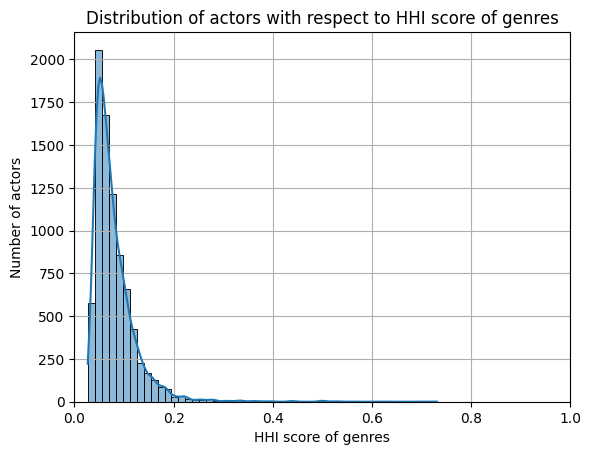

In [343]:
sns.histplot(actors_characters_personas_genres.drop_duplicates("freebase_actor_id")[actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_GENRES]["hhi_genre"], bins=50, kde=True)
plt.xlabel("HHI score of genres")
plt.ylabel("Number of actors")
plt.xlim([0,1])
plt.title("Distribution of actors with respect to HHI score of genres")
plt.grid()
plt.show()

#### MIP

In [344]:
# Retrieve movies for which we have characters
movies_from_characters = actors_characters.wiki_movie_id.unique()
movies_with_characters = movies[movies.wiki_movie_id.isin(movies_from_characters)].reset_index(drop = True).copy()

# Retrieve global genre distribution
all_movie_genres = movies_with_characters["genres"]

# Compute the entropy of movie genres
movie_frequency_genre = dict(Counter(all_movie_genres.explode().to_list()))
movie_genre_prior_h = scipy.stats.entropy(list(movie_frequency_genre.values()), base=2)

In [345]:
actors_characters_personas_genres["mip_genre"] = actors_characters_personas_genres["genres_freq"].apply(lambda genre_freq: calculate_mip(genre_freq, movie_genre_prior_h))

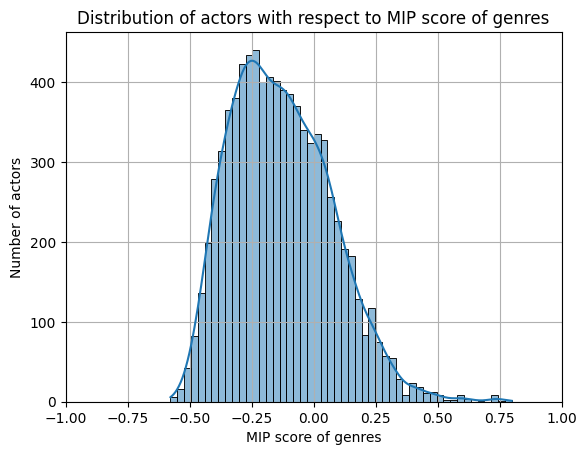

In [346]:
sns.histplot(actors_characters_personas_genres.drop_duplicates("freebase_actor_id")[actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_GENRES]["mip_genre"], bins=50, kde=True)
plt.xlabel("MIP score of genres")
plt.ylabel("Number of actors")
plt.xlim([-1,1])
plt.title("Distribution of actors with respect to MIP score of genres")
plt.grid()
plt.show()

### Movie personas

In [347]:
# This parameter allows us to filter out actors that did not play many movies
MINIMUM_NUM_MOVIES_PERSONAS = 3

#### HHI

In [348]:
actors_characters_personas_genres["hhi_personas"] = actors_characters_personas_genres["trope_distrib"].apply(calculate_hhi)

In [349]:
# Aggregate per actor
average_hhi_per_actor = actors_characters_personas_genres[actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_PERSONAS][["freebase_actor_id", "hhi_personas"]].groupby("freebase_actor_id").agg("mean").reset_index()

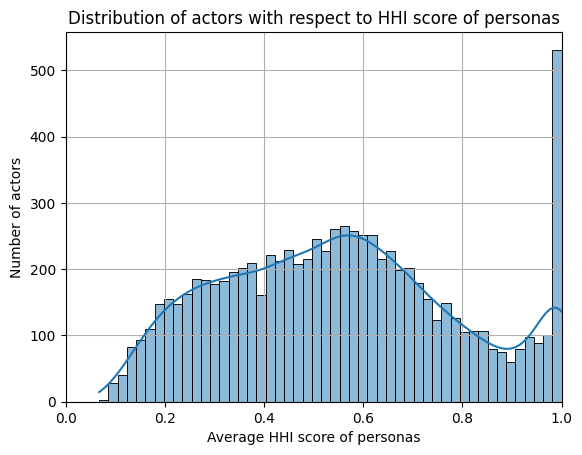

In [350]:
sns.histplot(average_hhi_per_actor["hhi_personas"], bins=50, kde=True)
plt.xlabel("Average HHI score of personas")
plt.ylabel("Number of actors")
plt.xlim([0,1])
plt.title("Distribution of actors with respect to HHI score of personas")
plt.grid()
plt.show()

#### MIP

In [351]:
# Retrieve all distinct character tropes
all_character_tropes = np.array([list(x) for x in actors_characters_personas.drop_duplicates("freebase_character_id")["trope_distrib"].copy()])

# Reconstruct global distribution
global_trope_distribution = np.mean(all_character_tropes, axis=0)

# Compute the entropy of personas
character_tropes_prior_h = scipy.stats.entropy(global_trope_distribution, base=2)

In [352]:
actors_characters_personas_genres["mip_personas"] = actors_characters_personas_genres["trope_distrib"].apply(lambda trope_distrib: calculate_mip(trope_distrib, character_tropes_prior_h))

In [353]:
# Aggregate per actor
average_mip_per_actor = actors_characters_personas_genres[actors_characters_personas_genres["total_movies"] >= MINIMUM_NUM_MOVIES_PERSONAS][["freebase_actor_id", "mip_personas"]].groupby("freebase_actor_id").agg("mean").reset_index()

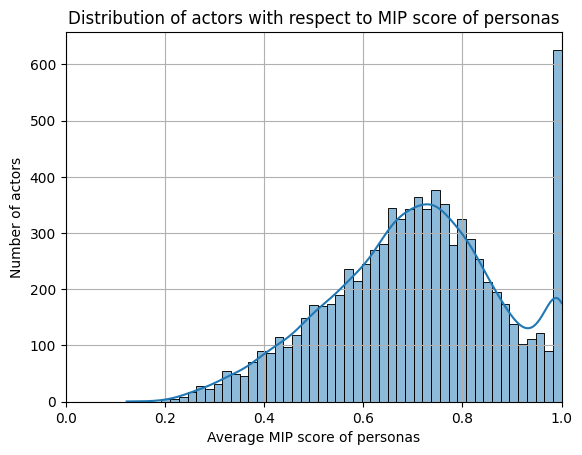

In [354]:
sns.histplot(average_mip_per_actor["mip_personas"], bins=50, kde=True)
plt.xlabel("Average MIP score of personas")
plt.ylabel("Number of actors")
plt.xlim([0,1])
plt.title("Distribution of actors with respect to MIP score of personas")
plt.grid()
plt.show()

### Summary & Interpretation

In [355]:
# Notice the 4 new columns with scores
actors_characters_personas_genres.head()

,freebase_map_id,movie_name,token_occurences,estimated_trope,trope_distrib,wiki_movie_id,freebase_id,release_date,character_name,actor_birth,...,actor_name,release_actor_age,freebase_character_id,freebase_actor_id,total_movies,genres_freq,hhi_genre,mip_genre,hhi_personas,mip_personas
0,/m/02vcl4m,Halls of Montezuma,5,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00999999...",10004330,/m/02pzjvb,1950,Pigeon Lane,1919-02-18,...,Jack Palance,30.0,/m/0h5cz0m,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,-0.404584,0.8484,0.883587
1,/m/0jwnks,Contempt,6,2,"[0.0, 0.0, 0.7699999809, 0.0, 0.0, 0.0, 0.0199...",1109777,/m/046t_0,1963,Jeremy Prokosch,1919-02-18,...,Jack Palance,43.0,/m/0by49h9,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,-0.404584,0.6230,0.779764
2,/m/03jrzwk,Monte Walsh,5,30,"[0.0, 0.0, 0.019999999600000002, 0.2899999917,...",12122757,/m/02vqjnv,2003-01-17,Chet Rollins,1919-02-18,...,Jack Palance,83.0,/m/0h5cz5s,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,-0.404584,0.2564,0.521911
3,/m/03jrt6y,The Professionals,15,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1443103,/m/051_vd,1966-11-02,Jesus Raza,1919-02-18,...,Jack Palance,47.0,/m/0h5cz2s,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,-0.404584,1.0000,1.000000
4,/m/0k1qv6,Panic in the Streets,20,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1611941,/m/05glbt,1950,Blackie,1919-02-18,...,Jack Palance,30.0,/m/0h5cz6_,/m/02t_w8,62,"[0.0, 0.0, 0.0766129032, 0.0040322581, 0.00403...",0.043119,-0.404584,1.0000,1.000000


In [ ]:
# TODO Luca stopped cleanup here ----------------------

**Interpretation:**
- Peak Near Zero: A concentration of actors with low HHI scores suggests that most actors in your dataset play a variety of roles and are not limited to a specific genre.
- Left-Skewed Distribution: The fact that the distribution tails off to the right indicates that fewer actors are consistently appearing in the same genre.
- Long Tail: The long tail towards the higher HHI scores suggests that while there are actors who are typecast, they are in the minority.


**Limitation:**
- This first approach presuppose that the prior distribution of role is uniform (which is clearly not the case). A more robust approach should be use to isolate the effect of the prior distribution

**Conclusions:**
- Diversity in Roles: There is a significant diversity in the roles that actors play, with many taking on a wide range of genres.
- Limited Typecasting: Only a small proportion of actors may be typecast into specific genres, as indicated by the tail of the distribution.

In [117]:
# Define the HHI score thresholds for low, medium, and high typecasting
low_threshold = 0.1
medium_threshold = 0.3

# Create a new column for HHI Category
actors_characters_personas_genres['HHI Category'] = pd.cut(actors_characters_personas_genres['HHI'], 
                                                           bins=[0, low_threshold, medium_threshold, 1], 
                                                           labels=['Low', 'Medium', 'High'])

category_counts = actors_characters_personas_genres['HHI Category'].value_counts()

# Calculate the proportions
category_proportions = category_counts / len(actors_characters_personas_genres)


category_proportions

KeyError: 'HHI'

-  79.31% of actors have a low HHI score, indicating they have a diverse range of roles across various genres. This is the largest category and suggests that the vast majority of actors are not being typecast and are instead taking on a variety of roles.

-  17.36% of actors fall into the medium category, which means they have some level of specialization but not to the extent that they are being strongly typecast. These actors may have a few genres they appear in more frequently than others, but they still have a mix in their filming carrer.

- 3.32% of actors have a high HHI score, suggesting that they tend to play roles in a limited range of genres, indicating a higher level of typecasting. Relatively few actors have consistenly recurrent roles.


In [ ]:
mip_scores = actors_characters_personas_genres['MIP']
plt.figure(figsize=(10, 6))
sns.histplot(mip_scores, bins=50, kde=True, stat="probability")
plt.title('Distribution of Herfindahl-Hirschman Index (MIP) Scores')
plt.xlabel('MIP Score')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

KeyError: 'MIP'

### When did an actor start to play in similar movies/similar characters?

The idea of this part is to determine if there are tends in the progression of tropes preferences in actors lifetime. The hypothesis we want to test for is that young actor don't have a saying in what role they want to play. However when casting actors that are very famous, the general public (and therefore the producer) already have an idea on which role this actor will play in. 

This research question is quite hard to answer due to the fact that a lot of actors haven't played in many movies. As such it is only possible to reliable study this question on actors that have succeeded (aka. are famous enought to play in many movies).

##### Method 1: Kullback-Leibler Divergence

- First of as said previously this method only makes sense if we have enought movies to work with (as such we are going to keep actors that has played at least $\alpha$ movies)

- We will order the movies chronologically and we will only keep the first $\beta %$ movies ($\beta$ is the treshold), we will denote those by $Q_{\beta}$

- We will consider the distribution of tropes for an actor accross its whole carrier (denoted $P$) and find a way to measure the excess surprise that we observed the distribution $Q_{\beta}$ when the actual distribution is $P$

  - The KL-divergence could be used to measure this however we only have a really rought estimate of the distribution of $Q_{\beta}$ (having only $\beta$ sample)

  - To fix this we will consider the log-likelihood of our observation. Consider the following likelihood 

  $$
    k(a; \beta) = - \frac{1}{\beta} \sum_{x \in F_a; i = 0}^{\beta} \log p(x | Q)
  $$

## Is there a clear distribution shift in the performance of a movie when this actor is/isn't in his comfort zone

We want to dertermine whether an actor playing outside of its *comfort* zone will have a negative impact on the movie. 

In [212]:

# Add a column for movie genre
actor_movie_genre = actors_characters_personas_genres[['freebase_id', 'freebase_actor_id']]
actor_movie_genre = actor_movie_genre.merge(movies[['freebase_id', 'genres', 'movie_release_date']], on='freebase_id', how='left')
actor_movie_genre.head()

,freebase_id,freebase_actor_id,genres,movie_release_date
0,/m/02pzjvb,/m/02t_w8,"[Action, Adventure, Drama]",1950
1,/m/046t_0,/m/02t_w8,"[Drama, Romance]",1963
2,/m/02vqjnv,/m/02t_w8,[Western],2003-01-17
3,/m/051_vd,/m/02t_w8,"[Action, Adventure, Drama]",1966-11-02
4,/m/05glbt,/m/02t_w8,"[Crime, Drama, Film-Noir]",1950


In [213]:
# List all genres
genres = list({y for ys in actor_movie_genre['genres'].to_list() for y in ys})

def extract_distribution(xs, refs):
    # xs = [y for ys in list(xs) for y in ys]
    xs = np.array([[x.count(ref) for ref in refs] for x in xs], dtype=np.float32)
    xs = xs / np.sum(xs, axis=1, keepdims=True)
    return np.mean(xs, axis=0)

# Group by actor and compute the prior distribution of movie genres per actor
df = actor_movie_genre[['freebase_actor_id', 'genres', 'freebase_id']] \
    .groupby('freebase_actor_id') \
    .aggregate({'genres': lambda xs: extract_distribution(xs, genres), 'freebase_id': 'count'}) \
    .rename(columns={'freebase_id': 'total_movies'}) \
    .reset_index()

In [214]:
# Find all actors with less than 5 movies
filtered_actors_id = set(df[df['total_movies'] < 15]['freebase_actor_id'].to_list())

# Filter actors on both dataset based on the previous list
df = df[~df['freebase_actor_id'].isin(filtered_actors_id)]
actor_movie_genre = actor_movie_genre[~actor_movie_genre['freebase_actor_id'].isin(filtered_actors_id)]

# Compute the MIP score per actor
df['MIP'] = preference_metrics_mutual_information(df['genres']) # FUNCTION NAME HAS CHANGED
df['HHI'] = df['genres'].apply(calculate_hhi)

In [215]:
print(len(actor_movie_genre))

7314


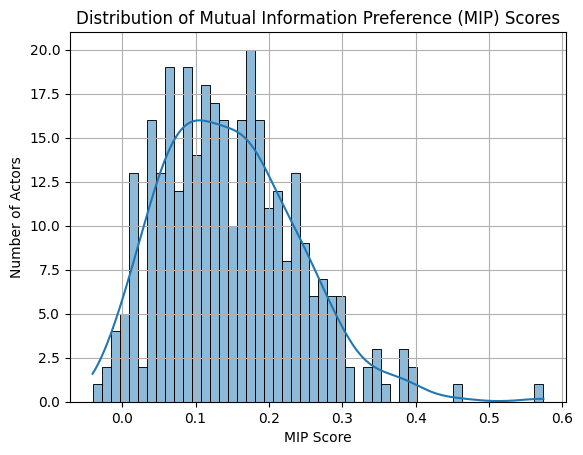

In [216]:
sns.histplot(df['MIP'], bins=50, kde=True)
plt.title('Distribution of Mutual Information Preference (MIP) Scores')
plt.xlabel('MIP Score')
plt.ylabel('Number of Actors')
plt.grid(True)
plt.show()

In [217]:
df.head(1)

,freebase_actor_id,genres,total_movies,MIP,HHI
1,/m/010xjr,"[0.012345679, 0.33950618, 0.024691358, 0.03086...",27,0.090582,0.176879


In [218]:
# For each roles of each actor, define the likelihood of the actor to play in this genre
def log_likelihood(df, priors):
    indices = [[genres.index(x) for x in xs] for xs in df["genres"]]

    # Compute the likelihood of each genre
    priors_dict = {}
    log_likelihood = []
    for idx, actor_id in enumerate(df["freebase_actor_id"]):
        if actor_id not in priors_dict:
            a_variable = priors[priors["freebase_actor_id"] == actor_id]
            priors_dict[actor_id] = a_variable.iloc[0]["genres"]

        prior = priors_dict[actor_id]
        log_likelihood.append(np.sum(np.log([prior[index] for index in indices[idx]])))

    return log_likelihood

actor_movie_genre['log_likelihood'] = log_likelihood(actor_movie_genre, df)

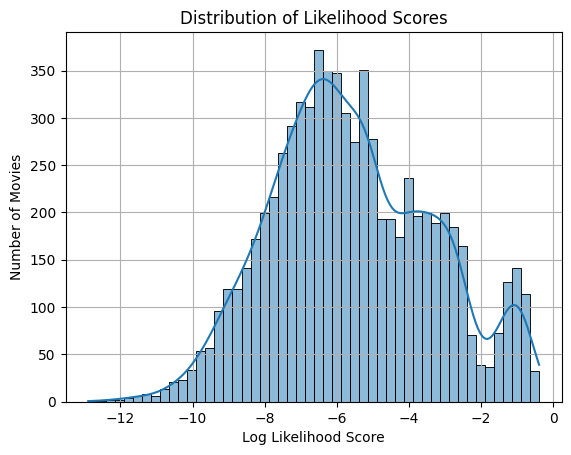

In [219]:
# Plot the distribution of likelihood
sns.histplot(actor_movie_genre['log_likelihood'], bins=50, kde=True)
plt.title('Distribution of Likelihood Scores')
plt.xlabel('Log Likelihood Score')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

In [220]:
# Extract a metric to describe the success of a movie
# Merge it with the previous dataset
movies_df = movies[['freebase_id', 'box_office', 'averageRating', 'numVotes']]
actor_movie_genre = actor_movie_genre.merge(movies_df, on='freebase_id', how='left')
actor_movie_genre = actor_movie_genre.merge(df[['freebase_actor_id', 'MIP', 'HHI']], on='freebase_actor_id', how='left')
actor_movie_genre.head()

,freebase_id,freebase_actor_id,genres,movie_release_date,log_likelihood,box_office,averageRating,numVotes,MIP,HHI
0,/m/02pzjvb,/m/02t_w8,"[Action, Adventure, Drama]",1950,-6.343611,2650000.0,6.6,2908,-0.009469,0.099874
1,/m/046t_0,/m/02t_w8,"[Drama, Romance]",1963,-5.154027,NaN,7.5,35214,-0.009469,0.099874
2,/m/02vqjnv,/m/02t_w8,[Western],2003-01-17,-1.791759,NaN,7.0,2971,-0.009469,0.099874
3,/m/051_vd,/m/02t_w8,"[Action, Adventure, Drama]",1966-11-02,-6.343611,19537346.0,7.3,18328,-0.009469,0.099874
4,/m/05glbt,/m/02t_w8,"[Crime, Drama, Film-Noir]",1950,-7.414052,NaN,7.2,8591,-0.009469,0.099874


### Method 1 : 

In [231]:
### Method 1: Analysis using linear regression and OLS
# A bit hacky, but we need to add a constant before using OLS (to reduce R²)
actor_movie_genre['const'] = np.ones_like(actor_movie_genre['log_likelihood'])
sm.OLS(actor_movie_genre['averageRating'], actor_movie_genre[['log_likelihood', 'MIP', 'const']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averageRating   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.875
Date:                Wed, 13 Dec 2023   Prob (F-statistic):            0.00282
Time:                        16:48:52   Log-Likelihood:                -9571.5
No. Observations:                7314   AIC:                         1.915e+04
Df Residuals:                    7311   BIC:                         1.917e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
log_likelihood     0.0134      0.005      2.724      0.006       0.004       0.023
MIP               -0.3453      0.122     -2.827      0.005      -0.585      -0.106
const              6.6423      0.038    174.026      0.000       6.567       6.717
==============================================================================
Omnibus:                      504.680   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              792.390
Skew:                          -0.552   Prob(JB):                    8.60e-173
Kurtosis:                       4.174   Cond. No.                         72.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

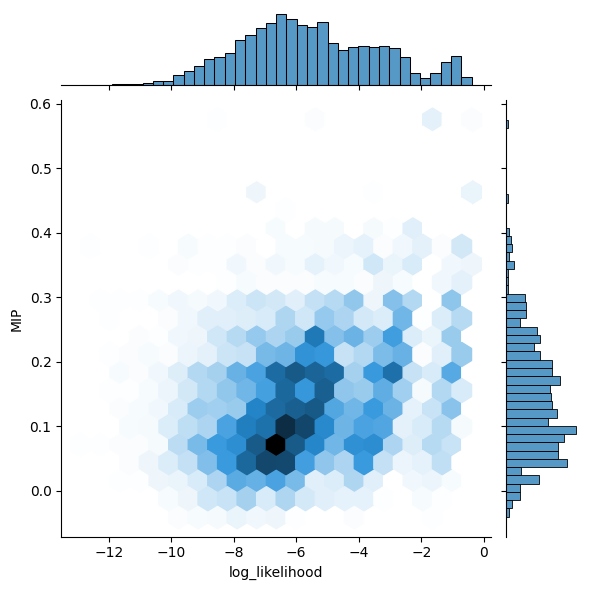

In [222]:
# Plot each movie with the likelihood and mip using the sns jointplot
sns.jointplot(x='log_likelihood', y='MIP', data=actor_movie_genre, kind='hex', gridsize=20)

<Axes: xlabel='averageRating', ylabel='Count'>

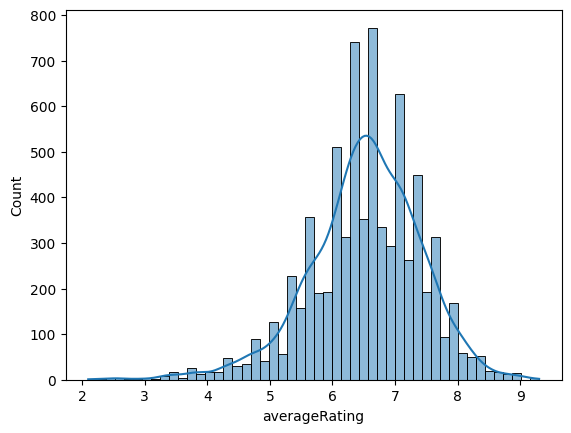

In [223]:
# Plot average rating distribution
sns.histplot(actor_movie_genre['averageRating'], bins=50, kde=True)

In [224]:
# Build categories for the movie ratings based on the quantiles (Low, Medium, High)
# actor_movie_genre['rating_category'] = pd.qcut(actor_movie_genre['averageRating'], q=3, labels=['Low', 'Medium', 'High'])

# Manully cut the rating into 3 categories (Low, Medium, High) based on (< 6, 6 - 7, > 7)
actor_movie_genre['rating_category'] = pd.cut(actor_movie_genre['averageRating'], bins=[0, 6, 7, 10], labels=['Low', 'Medium', 'High'])

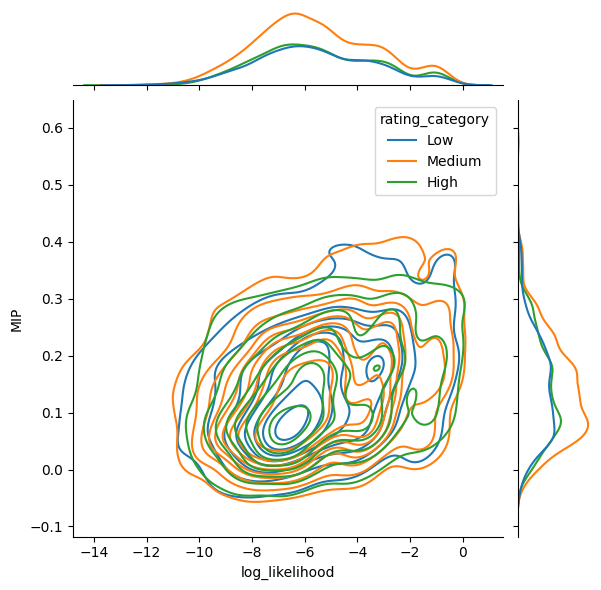

In [210]:
# Plot the distribution of likelihood and MIP for each category using jointplot
sns.jointplot(data= actor_movie_genre, x='log_likelihood', y='MIP', kind='kde', hue="rating_category", density=True)

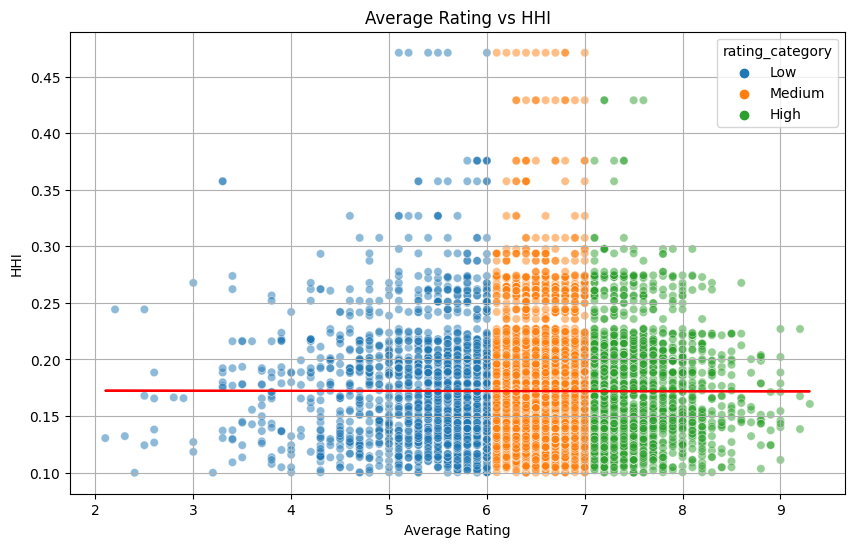

In [226]:
# Scatter plot of MIP vs average rating + regression line using pyplot
# and WITHOUT using seaborn

# Regression using numpy
y = actor_movie_genre['HHI']
x = actor_movie_genre['averageRating']
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

# Plot the scatter plot
plt.figure(figsize=(10, 6))
# plt.scatter(actor_movie_genre['HHI'], actor_movie_genre['averageRating'], alpha=0.3)
sns.scatterplot(data=actor_movie_genre, x='averageRating', y='HHI', alpha=0.5, hue='rating_category')
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.ylabel('HHI')
plt.xlabel('Average Rating')
plt.title('Average Rating vs HHI')
plt.grid(True)
plt.show()